In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import Ridge

In [2]:
# Loading data and data processing
df_train = pd.read_csv("MEPS_data_preprocessed_train.csv")
df_test = pd.read_csv("MEPS_data_preprocessed_test.csv")


df_train.drop(columns = ['PANEL', 'PERSONWT'], inplace=True)
df_test.drop(columns = ['PANEL', 'PERSONWT'], inplace=True)


# Logarithmic transforamtion of healthexpenses
val_train = df_train['HEALTHEXP'].values
df_train['HEALTHEXP'] = np.array([0 if v == 0 else np.log(v) / np.log(3) for v in val_train])
val_test = df_test['HEALTHEXP'].values
df_test['HEALTHEXP'] = np.array([0 if v == 0 else np.log(v) / np.log(3) for v in val_test])

print("Data head")
df_train.head(10)


Data head


,REGION,AGE31X,GENDER,RACE3,MARRY31X,EDRECODE,FTSTU31X,ACTDTY31,HONRDC31,RTHLTH31,...,ADSMOK42,PCS42,MCS42,K6SUM42,PHQ242,EMPST31,POVCAT15,INSCOV15,INCOME_M,HEALTHEXP
0,1,49,1.0,0.0,1,16,-1,2,2,1,...,1,51.29,59.04,1,0,1,3,1,8400.0,6.633424
1,3,43,1.0,0.0,4,14,-1,2,2,5,...,1,19.36,31.90,14,2,4,1,2,0.0,8.697717
2,1,75,1.0,0.0,1,13,-1,4,2,4,...,2,25.23,45.46,6,2,4,4,1,22619.0,9.991606
3,1,26,0.0,1.0,5,13,-1,2,2,1,...,2,49.13,63.97,4,0,1,3,1,20000.0,0.000000
4,3,43,1.0,0.0,9,14,-1,2,2,1,...,-1,-1.00,-1.00,-1,-1,1,4,1,58000.0,9.917560
5,1,18,1.0,1.0,5,2,1,2,2,1,...,2,57.78,59.96,0,0,4,5,1,0.0,6.061551
6,2,54,1.0,1.0,1,14,-1,2,2,5,...,-1,-1.00,-1.00,-1,-1,1,3,1,28477.0,9.874272
7,1,18,1.0,0.0,5,13,1,2,2,2,...,2,53.46,57.33,0,0,1,4,1,13650.0,8.121511
8,2,43,0.0,0.0,1,15,-1,2,2,1,...,2,57.76,57.06,0,0,1,5,1,219555.0,7.229773
9,4,42,1.0,0.0,5,14,-1,2,2,2,...,2,53.66,29.97,10,2,1,4,1,53000.0,7.451641


In [3]:
from sklearn.preprocessing import MinMaxScaler


inx_to_minmax_scale = ['RTHLTH31', 'MNHLTH31', 'POVCAT15'] 

scaler = MinMaxScaler()

for col in inx_to_minmax_scale:
    val = df_train[col].values 
    df_train[col] = scaler.fit_transform(val.reshape(-1,1)) 
    val = df_test[col].values 
    df_test[col] = scaler.fit_transform(val.reshape(-1,1)) 
    
# One extra column - how many times tested positive 
cat_inx = df_train.nunique()[df_train.nunique() == 3 ].index.tolist()
cat_inx.remove('INSCOV15')
fn = lambda row: sum([row[n]  for n in cat_inx if row[n] == 1])
col_train = df_train.apply(fn, axis=1)
col_test = df_test.apply(fn, axis=1)
df_train = df_train.assign(POSVT=col_train.values)
df_test = df_test.assign(POSVT=col_test.values)

In [4]:
x_train = df_train.drop(["HEALTHEXP"], axis = 1)
y_train = df_train["HEALTHEXP"]
x_test = df_test.drop(["HEALTHEXP"], axis = 1)
y_test = df_test["HEALTHEXP"]

In [5]:
def get_model_results(model_name: str, pred_train, y_train, pred_test, y_test, print_res):
    rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
    r_2_train = r2_score(y_train, pred_train)
    rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))
    r_2_test = r2_score(y_test, pred_test)
    mae_test = mean_absolute_error(y_test, pred_test)
    mae_train = mean_absolute_error(y_train, pred_train)

    if print_res:
        print(f"{model_name} results:")
        print(f"training rmse: {rmse_train}\ntraining r2: {r_2_train}\ntraining mae: {mae_train}")
        print(f"test rmse: {rmse_test}\ntest r2: {r_2_test}\ntest mae: {mae_test}\n")

    return [rmse_train, rmse_test,  r_2_train, r_2_test,  mae_train,  mae_test]

In [6]:
param = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20, 30, 40, 50, 100, 150, 200]}
ridge = Ridge()
ridge_regressor = GridSearchCV(ridge, param, cv=5)
ridge_regressor.fit(x_train, y_train)
pred_rr_test = ridge_regressor.predict(x_test)
pred_rr_train = ridge_regressor.predict(x_train)

ridge_res = get_model_results("Ridge Regression", pred_rr_train, y_train, pred_rr_test, y_test, True)

Ridge Regression results:
training rmse: 2.266885671580016
training r2: 0.3260554024765099
training mae: 1.717582420692549
test rmse: 2.2507713632601125
test r2: 0.32688702912191125
test mae: 1.6984020041883288



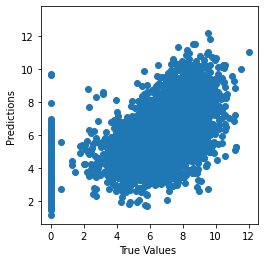

In [7]:
g=plt.scatter(y_test, pred_rr_test)
g.axes.set_xlabel('True Values ')
g.axes.set_ylabel('Predictions ')
g.axes.axis('equal')
g.axes.axis('square')
plt.savefig("linear_test_pred")

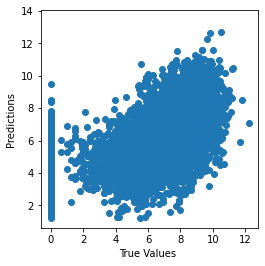

In [8]:
g=plt.scatter(y_train, pred_rr_train)
g.axes.set_xlabel('True Values ')
g.axes.set_ylabel('Predictions ')
g.axes.axis('equal')
g.axes.axis('square')
plt.savefig("linear_train_pred")